In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from timeit import timeit
import sys
import os
import seaborn
import ast

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import zscore

In [4]:
sys.setrecursionlimit(10**8)

In [5]:
global DataFrequency

DataFrequency = '1T'

In [4]:
def create_csv(file_name):

    PAIR_NAME = file_name.split('.')[0]
    if not os.access('backTEST', os.F_OK):
        os.mkdir('backTEST')

    if not os.access(f'backTEST/{PAIR_NAME}', os.F_OK):
        os.mkdir(f'backTEST/{PAIR_NAME}')

    inp_data = pd.read_csv(f'testData/{file_name}', index_col=1)
    # inp_data = pd.read_csv('testData/EURGBP.csv', index_col=0)
    inp_data.index = pd.to_datetime(inp_data.index)

    """EURGBP columns rename"""
    # inp_data.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, inplace=True)
    """DATABASE columns drop"""
    inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

    def create_grid(pam_grid_obj):
        CAP = 100_000
        slippage = 10
        BuyLossPercent = pam_grid_obj['BuyLossPercent']
        SellLossPercent = pam_grid_obj['BuyLossPercent']
        BuyTakePercent = pam_grid_obj['BuyTakePercent']
        SellTakePercent = pam_grid_obj['BuyTakePercent']
        MaxHold = pam_grid_obj['MaxHold']
        WindowRoll = pam_grid_obj['WindowRoll']
        Y_STD = pam_grid_obj['Y_STD']


        # Массив параметров
        PARAMS = {'Capital': CAP,
                  'slippage': slippage,
                  'slippagePerCap': slippage / CAP,
                  'window_rolling': WindowRoll,
                  'Y_threshold': Y_STD,
                  'max_hold_period': MaxHold,
                  'stopLossesPercent':{
                      'BuyLossPercent': BuyLossPercent / 100,
                      'SellLossPercent': SellLossPercent / 100,
                  },
                  'takePercent':{
                      'SellTakePercent': BuyTakePercent / 100,
                      'BuyTakePercent': SellTakePercent / 100,
                  },
                  'shift_param': int(pd.Timedelta(WindowRoll) / pd.Timedelta(DataFrequency)),
                  'time_barrier_param': int(pd.Timedelta(MaxHold) / pd.Timedelta(DataFrequency))
                  }
        del CAP, slippage, BuyLossPercent, SellLossPercent, BuyTakePercent, SellTakePercent, MaxHold, WindowRoll, Y_STD
        return PARAMS


    def calculate_max_drawdown(PNL_SERIES, dollars=True):
        """
        solution by Marco de Prado
        :param PNL_SERIES:
        :param dollars:
        :return:
        """
        dropout_df = PNL_SERIES.to_frame('pnl')
        dropout_df['hwm'] = dropout_df.expanding().max()
        df0 = dropout_df.groupby('hwm').min().reset_index()
        df0.columns = ['hwm', 'min']
        df0 = df0[df0['hwm'] > df0['min']]
        if dollars:
            dd = df0['hwm'] - df0['min']
        else:
            dd = df0['min'] / df0['hwm']

        return max(dd)

    def _estimator(data_frame, params_dict, show=False):
        DF_lines = []
        save_frame = data_frame.copy()
        # Считается параметр насколько нужно обрезать данные для адекватности сглаживания

        # Скользящее среднее
        data_frame.loc[:, 'rolling_mean'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).mean()

        # Скользящее отклонение
        data_frame.loc[:, 'rolling_std'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).std()

        # Отсечение данных имеющих
        # data_frame.drop(data_frame.index[:params_dict['shift_param']], axis=0, inplace=True)

        # Верхний уровень BBand
        data_frame.loc[:, 'HighBBand'] = round(data_frame.loc[:, 'rolling_mean'] + ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

        # Нижний уровень BBand
        data_frame.loc[:, 'LowBBand'] = round(data_frame.loc[:, 'rolling_mean'] - ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

        # Добавление номера линии для удобства
        data_frame['line_number'] = range(1, data_frame.shape[0] + 1)


        # correct_borders2 = data_frame.resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count()
        # correct_borders = tuple(data_frame.open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count() == float(params_dict['shift_param']))
        ab = list(zip(data_frame.copy().resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param'] - 1).rolling(params_dict['window_rolling']).count().values, data_frame.copy().resample(DataFrequency).first().index))
        ab = pd.DataFrame(ab)
        # print('AB',len(ab))
        # print('DF',len(data_frame))
        ab.columns = ['value', 'time']
        ab.index = ab.time
        ab = ab.drop(['time'], axis=1)

        correct_borders = tuple(pd.merge(data_frame, ab, left_index=True, right_index=True).value == params_dict['shift_param'])
        # print('CB',len(correct_borders))
        dot_low_tuple = tuple(data_frame.low)
        dot_high_tuple = tuple(data_frame.high)
        dot_close_tuple = tuple(data_frame.close)
        LowBBand_tuple = tuple(data_frame.LowBBand)
        HighBBand_tuple = tuple(data_frame.HighBBand)

        cycle_buffer = -10
        ISX = 0
        if show:
            tqdm_bar = tqdm(total=data_frame.shape[0])

        while ISX < (data_frame.shape[0] / 1.1) and (cycle_buffer != ISX):
            openLogic = OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                         LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                         arrow_index=ISX, openParams=params_dict, correct_borders=correct_borders)

            openLogic['open_time'] = data_frame.index[openLogic['open_index']]
            closeLogic = HoldingPosition(open_logic=openLogic, dot_close_tuple=dot_close_tuple,
                            dot_high_tuple=dot_high_tuple, dot_low_tuple=dot_low_tuple,
                            holdParams=params_dict, arrow_index=openLogic['open_index'] + 1, time_border_counter=0)

            closeLogic['close_time'] = data_frame.index[closeLogic['close_index']]
            summary_dict = openLogic | closeLogic
            DF_lines.append(summary_dict)

            cycle_buffer = ISX
            ISX = closeLogic['close_index']
            if show:
                tqdm_bar.update(ISX - tqdm_bar.last_print_n)

        dfResults = pd.DataFrame(DF_lines)
        dfResults["profit"] = dfResults["position"] * (dfResults["close_price"] - dfResults["open_price"]) - params_dict["slippage"] if (dfResults["type_operation"] == 'BUY').bool else abs(dfResults["position"]) * (dfResults["open_price"] - dfResults["close_price"]) - params_dict["slippage"]
        dfResults.index = dfResults.close_time
        pnl_series = dfResults["profit"].cumsum()


        optimizePar = round(pnl_series[-1] / calculate_max_drawdown(pnl_series + params_dict['Capital']), 4)
        params_dict_opt = params_dict.copy()
        params_dict_opt['result'] = optimizePar
        return [optimizePar, params_dict_opt]

    def OpenPosition(dot_low_tuple, dot_high_tuple, LowBBand_tuple, HighBBand_tuple, arrow_index, openParams, correct_borders):
        """
        Проверяет возможно ли открыть сделку. В случае возможности возвращает информацию об открытой сделки
        :param current_dot:
        :param arrow_index:
        :return:
        """
        # Задается вид словаря описывающего информацию об открытии сделки
        ret_dict = {'type_operation': None,
                    'position': None,
                    'open_price': None,
                    'open_index': None,
                    'stop_loss_border': None,
                    'take_profit_border': None
                    }
        if arrow_index > len(dot_low_tuple):
            return 'InCorrectData'
        # Проверка о пересечении нижней границы
        if (dot_low_tuple[arrow_index] < LowBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
            ret_dict['type_operation'] = 'BUY'
            ret_dict['position'] = 1 * (openParams['Capital'] / LowBBand_tuple[arrow_index])
            ret_dict['open_price'] = LowBBand_tuple[arrow_index]
            ret_dict['open_index'] = arrow_index
            ret_dict['stop_loss_border'] = round(LowBBand_tuple[arrow_index] * (1 - openParams['stopLossesPercent']['BuyLossPercent']), 5)
            ret_dict['take_profit_border'] = round(LowBBand_tuple[arrow_index] * (1 + openParams['takePercent']['BuyTakePercent']), 5)

            return ret_dict
        # Проверка о пересечении верхней границы
        if (dot_high_tuple[arrow_index] > HighBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
            ret_dict['type_operation'] = 'SELL'
            ret_dict['position'] = -1 * (openParams['Capital'] / HighBBand_tuple[arrow_index])
            ret_dict['open_price'] = HighBBand_tuple[arrow_index]
            ret_dict['open_index'] = arrow_index

            ret_dict['stop_loss_border'] = round(HighBBand_tuple[arrow_index] * (1 + openParams['stopLossesPercent']['SellLossPercent']), 5)
            ret_dict['take_profit_border'] = round(HighBBand_tuple[arrow_index] * (1 - openParams['takePercent']['SellTakePercent']), 5)
            return ret_dict
        else:
            return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                                LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                                arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders)

    def HoldingPosition(open_logic, dot_close_tuple, dot_high_tuple, dot_low_tuple, holdParams, arrow_index, time_border_counter):
        if open_logic['type_operation'] == 'BUY':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
            elif dot_high_tuple[arrow_index] >= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}

            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)

        if open_logic['type_operation'] == 'SELL':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}
            elif dot_high_tuple[arrow_index] >= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)
    def plotter(test_df, qqq):
        plt.figure(figsize=(16,16))

        ax1 = plt.subplot(4,1,1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        ax2 = plt.subplot(4,1,2, sharex=ax1)
        ax2.set_title('Bbands')
        plt.plot(qqq.open, label='open', alpha=.5)
        plt.plot(qqq.high, label='high', alpha=.7, color='red')
        plt.plot(qqq.low, label='close', alpha=.7, color='yellow')
        plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='blue')
        plt.legend(loc='lower right')
        ax3 = plt.subplot(4,1,3, sharex=ax1)
        ax3.set_title('trades histogram')
        for _ in range(test_df.shape[0]):
            if test_df.iloc[_].type_operation == 'BUY':
                plt.axvline(x=test_df.iloc[_].open_time, color='green', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='green', alpha=.6, linewidth=.5)
            if test_df.iloc[_].type_operation == 'SELL':
                plt.axvline(x=test_df.iloc[_].open_time, color='red', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='red', alpha=.6, linewidth=.5)
            plt.hlines(xmin=test_df.iloc[_].open_time, xmax=test_df.iloc[_].close_time, y=test_df.open_price[_], color='black', linestyles='-')
        ax4 = plt.subplot(4,1,4, sharex=ax1)

        plt.show()

    def lightPlotter(test_df, qqq, final=False, show=False):
        plt.figure(figsize=(16,16))
        if not final:
            plt.title('InSample')
        if final:
            plt.title('OutOfSample')
        ax1 = plt.subplot(2, 1, 1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        ax2 = plt.subplot(2,1,2, sharex=ax1)
        ax2.set_title('Bbands')
        plt.plot(qqq.open, label='open', alpha=.5)
        plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        plt.plot(qqq.rolling_mean, label='MovingAverage', alpha=1, color='red')
        plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='yellow')
        plt.legend(loc='lower right')
        if not final:
            plt.savefig(f'backTEST/{PAIR_NAME}/bestInSample_{PAIR_NAME}.jpeg')
        if final:
            plt.savefig(f'backTEST/{PAIR_NAME}/outSample_{PAIR_NAME}.jpeg')
        if not show:
            plt.close()

    """WAY TO DELETE HOLIDAYS"""
    inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
    inp_data.index = inp_data.beautiful_time


    params = {
        "BuyLossPercent": np.linspace(.1, 1.2, 10),
        #"SellLossPercent": [20, 30, 40],
        "BuyTakePercent": np.linspace(.1, 1.2, 10),
        #"SellTakePercent": [20, 30, 40],
        "MaxHold": [str(int(x))+'T' for x in np.linspace(100, 2450, 15)],
        "WindowRoll": [str(int(x))+'T' for x in np.linspace(100, 650, 15)],
        "Y_STD": np.linspace(10, 300, 10)
              }
    grid = ParameterGrid(params)
    print(f"Grid len = {len(grid)}")
    # shuffled = pd.DataFrame(grid).sample(frac=1, random_state=20).reset_index(drop=True) # OLD PARAMS
    shuffled = pd.DataFrame(grid).sample(frac=1, random_state=21).reset_index(drop=True)

    # SHIFT = 400_000
    # RESULT = Parallel(n_jobs=-1, verbose=5, prefer="threads", require='sharedmem')(delayed(_estimator)(inp_data.copy().loc['2019-01-01': '2020-01-01'], create_grid(dict(shuffled.iloc[paramArrow])), show=False) for paramArrow in tqdm(range(shuffled[:45].shape[0]))) # OLD GRID
    RESULT = Parallel(n_jobs=-1, verbose=5, prefer="threads", require='sharedmem')(delayed(_estimator)(inp_data.copy().loc['2019-01-01': '2020-01-01'], create_grid(dict(shuffled.iloc[paramArrow])), show=False) for paramArrow in tqdm(range(shuffled[:745].shape[0])))

    optParams = [_[0] for _ in RESULT]
    optParams = shuffled.iloc[optParams.index(max(optParams))]
    PARAMS_DF = pd.DataFrame([_[1] for _ in RESULT])
    print('OPTIMAL_PARAMS:\n', optParams)
    optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2019-01-01': '2020-01-01'], params_dict=create_grid(dict(optParams)), show=True)
    # plotter(df, preprocessed_data)
    # lightPlotter(df, preprocessed_data)
    # print('INSAMPLE')
    # print(f"""Total trades: {df.shape[0]}
    # Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
    # Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    # Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    # Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    # Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    # StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    # TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    # endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    # """)

    # with open(f'backTEST/{PAIR_NAME}/best_InSample_stat.txt', 'w') as file:
    #     file.writelines(f"""
    #         Total trades:, {df.shape[0]}
    #         Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
    #         Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    #         Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    #         Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    #         Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    #         StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    #         TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    #         endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    #         """)

    optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-01'], params_dict=create_grid(dict(optParams)), show=True)
    # plotter(df, preprocessed_data)
    # lightPlotter(df, preprocessed_data, final=True)
    # print('OUTOFSAMPLE')
    # print(f"""Total trades: {df.shape[0]}
    # Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
    # Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    # Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    # Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    # Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    # StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    # TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    # endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    # """)
    #
    # with open(f'backTEST/{PAIR_NAME}/outsample_stat.txt', 'w') as file:
    #     file.writelines(f"""
    #         Total trades:, {df.shape[0]}
    #         Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
    #         Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
    #         Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
    #         Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
    #         Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
    #         StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
    #         TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
    #         endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
    #         """)
    #
    # df["own_time"] = df.close_time - df.open_time
    # plt.figure(figsize=(12,9))
    # plt.title('MarkOut')
    # ax = plt.subplot(1,1,1)
    # df.groupby(by='own_time').profit.mean().plot(marker='o', ax=ax)
    # plt.legend(loc='lower left')
    # plt.show()




    pd.DataFrame(PARAMS_DF).to_csv(f'backTEST/{PAIR_NAME}/result_{PAIR_NAME}.csv')

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1643/2963282085.py:268: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.8s
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Grid len = 225000
Traceback (most recent call last):
  File "/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1643/2963282085.py", line 288, in <module>
    RESULT = Parallel(n_jobs=-1, verbose=5, prefer="threads", require='sharedmem')(delayed(_estimator)(inp_data.copy().loc['2019-01-01': '2020-01-01'], create_grid(dict(shuffled.iloc[paramArrow])), show=False) for paramArrow in tqdm(range(shuffled[:745].shape[0])))
  File "/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/po

  0%|          | 0/745 [00:00<?, ?it/s]

TypeError: object of type 'NoneType' has no len()

In [98]:
PAIR_NAME = "AUDCAD"
# Read data and unpack losses and takeProfits
res = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{PAIR_NAME}.csv", index_col=0)
res["TakeProfit"] = res.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
res["StopLoss"] = res.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])

plot = res[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]

# Convert date type to floats
plot.loc[:, 'window_rolling'] = plot.loc[:,'window_rolling'].aggregate(lambda x: pd.Timedelta(x).total_seconds())
plot.loc[:, 'max_hold_period'] = plot.loc[:, 'max_hold_period'].aggregate(lambda x: pd.Timedelta(x).total_seconds())
abs_Z_scores = np.abs(zscore(plot.result))
filtered = (abs_Z_scores < 3)
print('OLD:', plot.shape)
plot = plot[filtered]
plot.reset_index(inplace=True, drop=True)
print('NEW:', plot.shape)

COLUMNS = plot.columns.values
COLUMNS = np.delete(COLUMNS, np.where(COLUMNS == 'result'))

# Scale data to normalize
scaler = StandardScaler()
# scaler = MinMaxScaler()
scaledPlot = pd.DataFrame(scaler.fit_transform(plot.drop('result', axis=1).values))

scaledPlot.columns = COLUMNS
scaledPlot.index = plot.index
scaledPlot
scaledPlot['result'] = plot['result']

OLD: (1245, 6)
NEW: (1227, 6)


/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<Figure size 1224x1080 with 0 Axes>

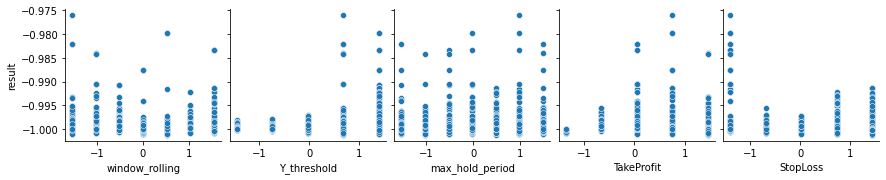

In [99]:
plt.figure(figsize=(17,15))
seaborn.pairplot(data=scaledPlot, x_vars=COLUMNS, y_vars=f"result")

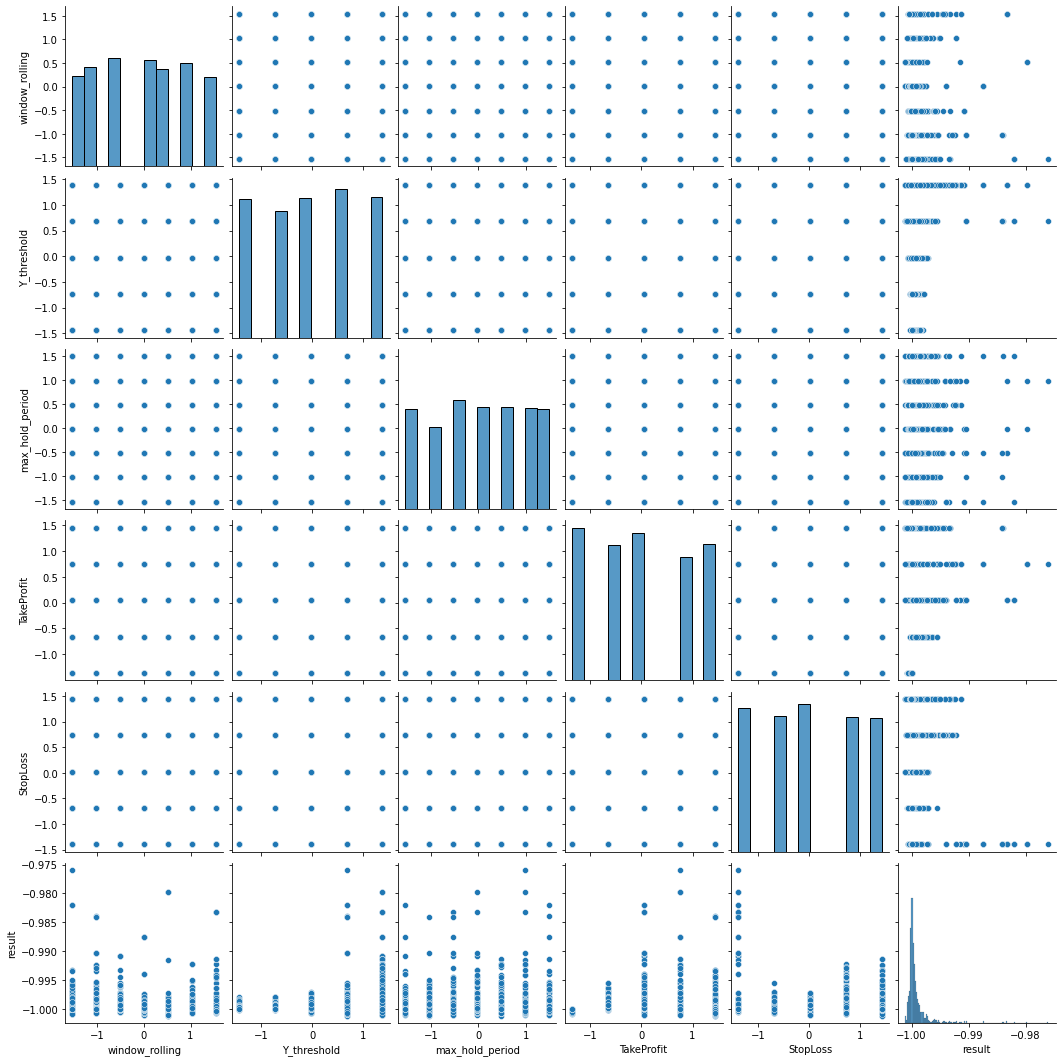

In [100]:
seaborn.pairplot(data=scaledPlot)

In [101]:
# Понижаем размерность
pca = PCA(n_components = 2, svd_solver='full')
XPCAreduced = pca.fit_transform(scaledPlot.drop('result', axis=1).values)
# XPCAreduced = pca.fit_transform(scaledPlot.values)
pca.explained_variance_ratio_

array([0.21310008, 0.2087578 ])

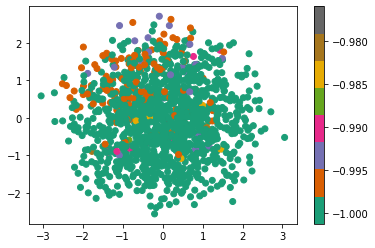

In [102]:
sc = plt.scatter(x=XPCAreduced.T[0], y=XPCAreduced.T[1], c=plot['result'], cmap='Dark2')
plt.colorbar(sc)

In [97]:
dotesOfInterest = [[-3, 2], [-3, 1], [3, 3], [-3, 3], [0, 2], [0, 1]]


dotesOfInterest = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(dotesOfInterest)))
dotesOfInterest.columns = COLUMNS

dotesOfInterest['window_rolling'] = dotesOfInterest['window_rolling'].aggregate(lambda x: str(int(x) // 60) + 'T')
dotesOfInterest['max_hold_period'] = dotesOfInterest['max_hold_period'].aggregate(lambda x: str(int(x) // 60) + 'T')

dotesOfInterest

,window_rolling,Y_threshold,max_hold_period,TakeProfit,StopLoss
0,548T,347.451555,136T,-0.000995,0.007639
1,601T,325.256028,151T,0.001538,0.005672
2,-67T,67.918345,2324T,0.001370,0.015054
3,494T,369.647081,121T,-0.003529,0.009605
4,267T,196.587186,1238T,0.001454,0.010363
5,321T,174.391659,1252T,0.003987,0.008396


0    548T
1    601T
Name: window_rolling, dtype: object

In [86]:
pca.explained_variance_ratio_

array([0.2322949 , 0.20456488])

In [60]:
"------"
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
scaledTSNE = tsne.fit_transform(scaledPlot.drop('result', axis=1).values)
scaledTSNE.shape

(724, 2)

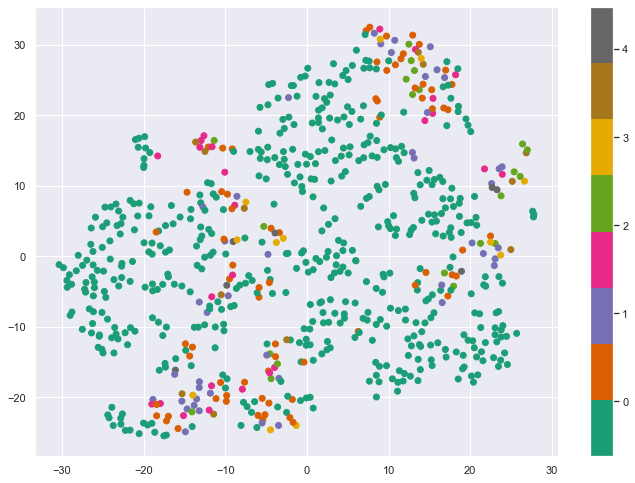

In [61]:
sc = plt.scatter(x=scaledTSNE.T[0], y=scaledTSNE.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

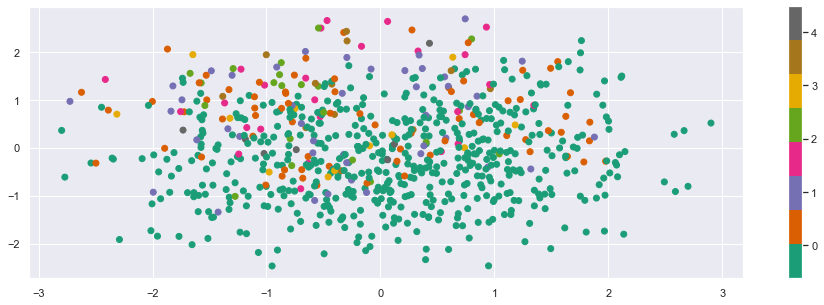

In [176]:
from sklearn.decomposition import KernelPCA

kernel = KernelPCA(n_components=2, kernel='linear')
KernelScaled = kernel.fit_transform(scaledPlot.drop('result', axis=1).values)

sc = plt.scatter(x=KernelScaled.T[0], y=KernelScaled.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

breaking at iteration 369 with stress 248374.71234342316
breaking at iteration 266 with stress 250128.98051867666
breaking at iteration 322 with stress 249576.4326713149
breaking at iteration 671 with stress 253888.36052404565


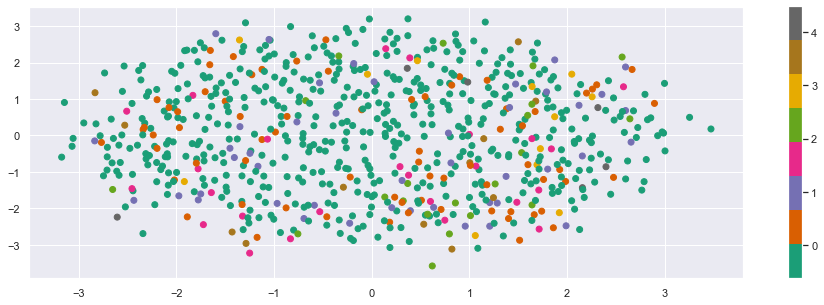

In [177]:
from sklearn.manifold import MDS

kernel = MDS(n_components=2, max_iter=1_500, verbose=1)
KernelScaled = kernel.fit_transform(scaledPlot.drop('result', axis=1).values)

sc = plt.scatter(x=KernelScaled.T[0], y=KernelScaled.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [ ]:
# https://www.machinelearningmastery.ru/feature-extraction-techniques-d619b56e31be/

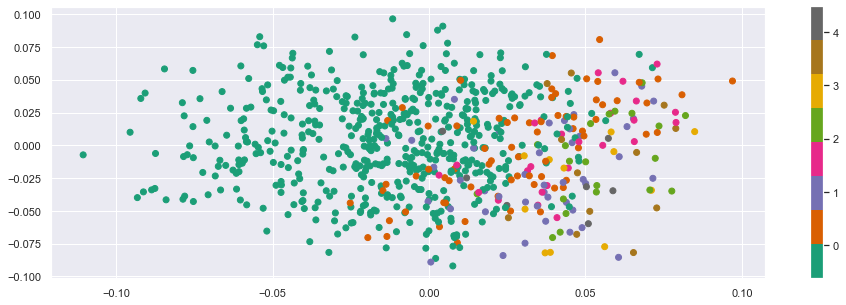

In [190]:
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding

embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=20)

X_lle = embedding.fit_transform(scaledPlot.drop('result', axis=1).values)
sc = plt.scatter(x=X_lle.T[0], y=X_lle.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

AttributeError: 'LocallyLinearEmbedding' object has no attribute 'feature_names_in_'

In [169]:
import umap.umap_


PAIR_NAME = "AUDCAD"
# Read data and unpack losses and takeProfits
res = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{PAIR_NAME}.csv", index_col=0)
res["TakeProfit"] = res.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
res["StopLoss"] = res.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])

plot = res[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]

# Convert date type to floats
plot.loc[:, 'window_rolling'] = plot.loc[:,'window_rolling'].aggregate(lambda x: pd.Timedelta(x).total_seconds())
plot.loc[:, 'max_hold_period'] = plot.loc[:, 'max_hold_period'].aggregate(lambda x: pd.Timedelta(x).total_seconds())
abs_Z_scores = np.abs(zscore(plot.result))
filtered = (abs_Z_scores < 3)
print('OLD:', plot.shape)
plot = plot[filtered]
plot.reset_index(inplace=True, drop=True)
print('NEW:', plot.shape)

COLUMNS = plot.columns.values
COLUMNS = np.delete(COLUMNS, np.where(COLUMNS == 'result'))

# Scale data to normalize
scaler = StandardScaler()
# scaler = MinMaxScaler()
scaledPlot = pd.DataFrame(scaler.fit_transform(plot.values))

scaledPlot.columns = plot.columns
scaledPlot.index = plot.index
scaledPlot

reducer = umap.umap_.UMAP(densmap=True, random_state=42, n_neighbors=100, verbose=True)

OLD: (745, 6)
NEW: (724, 6)


/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [170]:
embedding = reducer.fit_transform(scaledPlot)
embedding.shape

UMAP(densmap=True, n_neighbors=100, random_state=42, verbose=True)
Tue Feb 22 03:29:16 2022 Construct fuzzy simplicial set
Tue Feb 22 03:29:16 2022 Finding Nearest Neighbors
Tue Feb 22 03:29:16 2022 Finished Nearest Neighbor Search
Tue Feb 22 03:29:16 2022 Construct embedding
Tue Feb 22 03:29:16 2022 Computing original densities
Tue Feb 22 03:29:25 2022 Finished embedding


Epochs completed:   0%|            0/700 [00:00]

(724, 2)

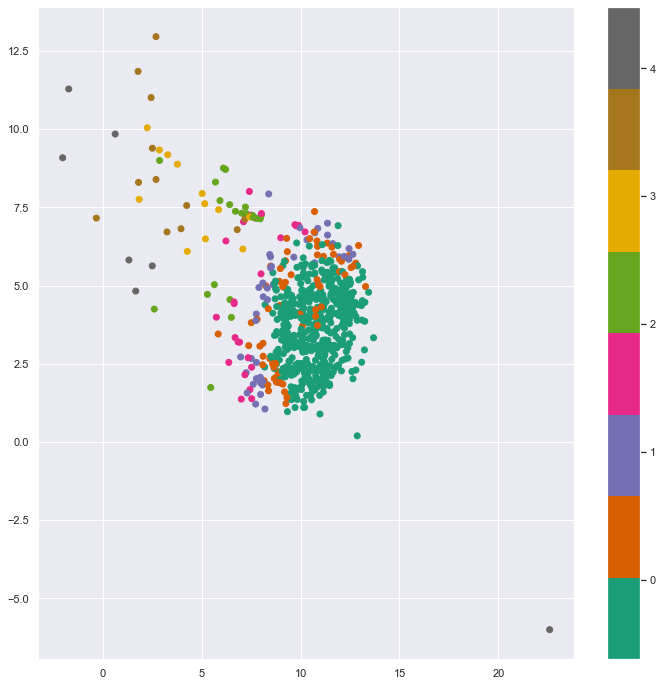

In [171]:
plt.figure(figsize=(12,12))
sc = plt.scatter(x=embedding.T[0], y=embedding.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [119]:
pd.DataFrame(reducer.inverse_transform(embedding))

ValueError: Inverse transform not available for densMAP.

In [114]:
scaledPlot

,window_rolling,Y_threshold,max_hold_period,result,TakeProfit,StopLoss
0,-0.477827,0.579096,0.456709,-0.560599,-1.581524,-1.181114
1,-0.952863,-1.610279,0.456709,-0.559656,-1.231364,-1.524263
2,0.466232,-0.150696,-1.336155,-0.373842,-1.581524,0.191481
3,0.466232,1.308887,1.129533,1.572019,-0.531044,0.191481
4,-0.952863,-0.150696,-0.887605,-0.520041,0.869596,-0.494817
...,...,...,...,...,...,...
719,-1.656397,-1.610279,-0.887605,-0.559656,1.219757,-1.524263
720,0.941268,0.943992,-0.887605,1.443741,0.519436,0.534630
721,1.410291,1.308887,-0.214781,0.438270,-0.531044,-0.494817
722,-0.477827,1.308887,0.232434,-0.467220,0.869596,-0.837966


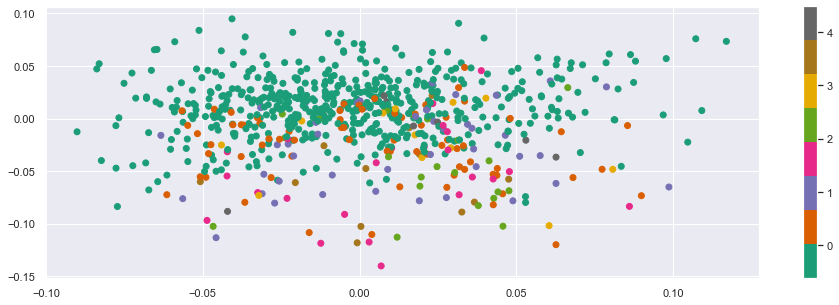

In [166]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding

kernel = LocallyLinearEmbedding(n_components=2,method='modified', n_neighbors=100)
KernelScaled = kernel.fit_transform(scaledPlot.drop('result', axis=1).values)

sc = plt.scatter(x=KernelScaled.T[0], y=KernelScaled.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)